## Bibliometric Analysis

In [1]:
!pip install plotly WordCloud

In [2]:
#import useful libraries

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.subplots as sp
import textwrap

In [3]:
# Load Data 
df = pd.read_csv("Screened_data.csv")

# pick correct column names
def get_col(possible):
    for c in df.columns:
        if c.lower().strip() in [p.lower() for p in possible]:
            return c
    return None

col_doc_type = get_col(["Document Type", "doctype"])
col_keywords = get_col(["Author Keywords", "authorkeywords"])
col_abstract = get_col(["Abstract", "abstract"])
col_authors = get_col(["Authors", "author"])
col_source = get_col(["Source title", "source", "journal"])
col_cites = get_col(["Cited by", "citedby", "citations"])
col_year = get_col(["Year", "year", "Publication Year"])

# Data preparation
# Document type
doc_counts = df[col_doc_type].value_counts(dropna=True)

# Summary statistics
summary_stats = {
    "Time Interval": f"{df[col_year].min()}:{df[col_year].max()}",
    "Sources": df[col_source].nunique(),
    "Papers": len(df),
    "The average age of the paper": round((df[col_year].max() - df[col_year]).mean(), 2),
    "Average citations per paper": round(df[col_cites].mean(), 3),
    "Keywords": df[col_keywords].dropna().str.split(";|,").map(len).sum(),
    "Author's Keywords": df[col_keywords].nunique(),
    "Authors": df[col_authors].nunique(),
    "Authors of single-authored papers": sum(df[col_authors].str.split(",").map(len) == 1),
    "Co-Authors per paper": round(df[col_authors].str.split(",").map(len).mean(), 2),
}
summary_table = pd.DataFrame(list(summary_stats.items()), columns=["Metric", "Value"])

# Keywords for word clouds
author_keywords = " ".join(str(x) for x in df[col_keywords].dropna())
abstract_keywords = " ".join(str(x) for x in df[col_abstract].dropna())

# Highly cited sources
top_sources = df.groupby(col_source)[col_cites].sum().sort_values(ascending=False).head(5).reset_index()
top_sources.columns = ["Source", "Total Citations"]

# Highly cited authors
top_authors = df.groupby(col_authors)[col_cites].sum().sort_values(ascending=False).head(5).reset_index()
top_authors.columns = ["Author", "Total Citations"]


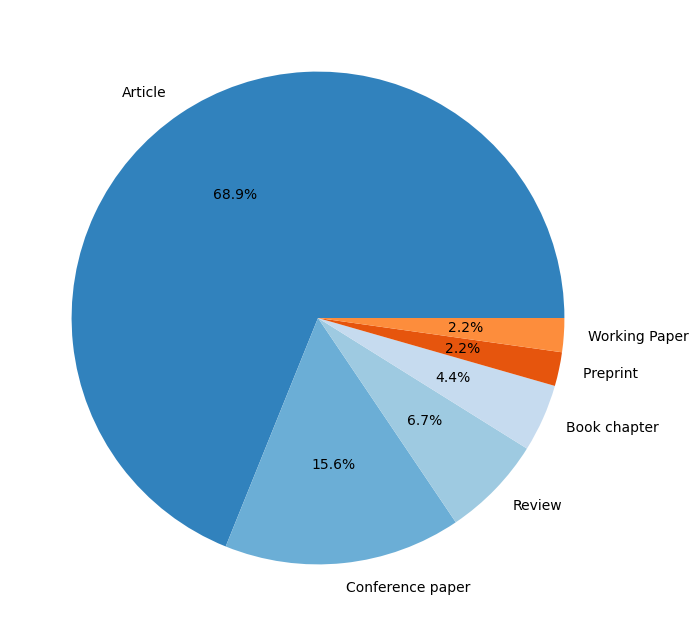

In [4]:
# 1. Document Type Plot 
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20c.colors[:len(doc_counts)]
plt.pie(doc_counts, labels=doc_counts.index, autopct='%1.1f%%', colors=colors)
#plt.title("Document Type", fontsize=18, pad=20)
plt.savefig("document_type.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
# 2. Print Tables
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(summary_table.to_string(index=False))
print("\n")

print("="*60)
print("TOP 5 HIGHLY CITED SOURCES/JOURNALS")
print("="*60)
print(top_sources.to_string(index=False))
print("\n")

print("="*60)
print("TOP 5 HIGHLY CITED AUTHORS")
print("="*60)
print(top_authors.to_string(index=False))
print("\n")

SUMMARY STATISTICS
                           Metric     Value
                    Time Interval 2010:2025
                          Sources        40
                           Papers        45
     The average age of the paper      6.38
      Average citations per paper    37.026
                         Keywords       209
                Author's Keywords        39
                          Authors        43
Authors of single-authored papers        39
             Co-Authors per paper      1.33


TOP 5 HIGHLY CITED SOURCES/JOURNALS
                           Source  Total Citations
    Journal of Cleaner Production            215.0
             Ecological Economics            199.0
   JOURNAL OF FINANCIAL STABILITY            143.0
      Global Environmental Change            139.0
Journal of Evolutionary Economics             95.0


TOP 5 HIGHLY CITED AUTHORS
                                                            Author  Total Citations
                                        

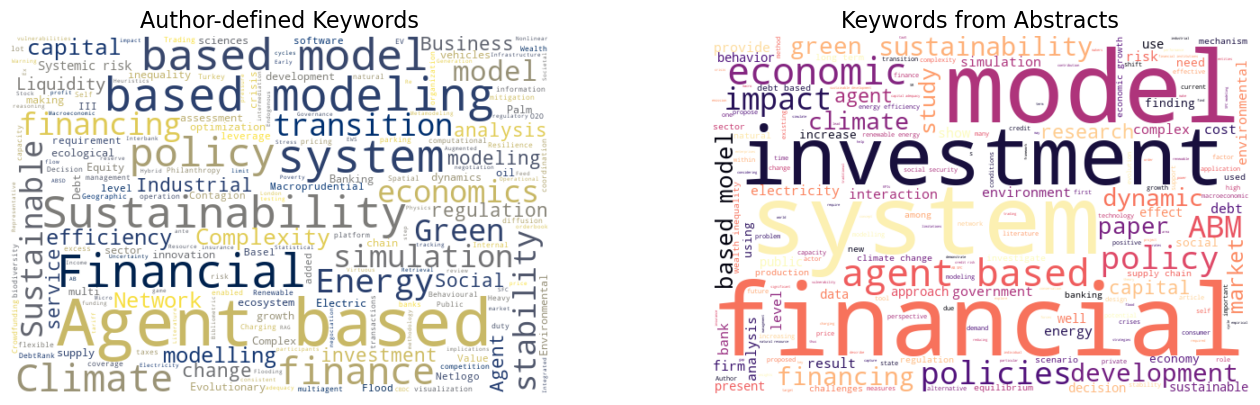

In [6]:
# 3. Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.3)

# Author-defined keywords word cloud
wc1 = WordCloud(width=600, height=400, background_color="white", colormap="cividis").generate(author_keywords)
axes[0].imshow(wc1, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Author-defined Keywords", fontsize=16)

# Keywords from abstracts word cloud
wc2 = WordCloud(width=600, height=400, background_color="white", colormap="magma").generate(abstract_keywords)
axes[1].imshow(wc2, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Keywords from Abstracts", fontsize=16)

plt.savefig("wordcloud_comparison.png", dpi=300, bbox_inches="tight")
plt.show()



In [7]:
#  4. Funnel Charts
def wrap_labels(labels, width=25):
    return ['<br>'.join(textwrap.wrap(str(l), width)) for l in labels]

# Wrap long labels
top_sources["Source_wrapped"] = wrap_labels(top_sources["Source"], width=25)
top_authors["Author_wrapped"] = wrap_labels(top_authors["Author"], width=25)

# Subplots with funnels
fig_combined = sp.make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Top 5 Highly Cited Sources/Journal", "Top 5 Highly Cited Authors"),
    horizontal_spacing=0.25
)

# Sources Funnel
fig_combined.add_trace(
    go.Funnel(
        y=top_sources["Source_wrapped"],
        x=top_sources["Total Citations"],
        textinfo="value",
        textposition="inside",
        marker=dict(color="lightblue")
    ),
    row=1, col=1
)

# Authors Funnel
fig_combined.add_trace(
    go.Funnel(
       y=top_authors["Author_wrapped"],
        x=top_authors["Total Citations"],
        textinfo="value",
        textposition="inside",
        marker=dict(color="lightblue")
    ),
    row=1, col=2
)

fig_combined.update_layout(
    showlegend=False,
    height=600,
    width=1300,
    margin=dict(l=100, r=100, t=100, b=80),
    plot_bgcolor="white")
fig_combined.write_html("funnel_dashboard.html")
fig_combined.show()

print("="*60)
print("FILES SAVED:")
print("- document_type.png")
print("- wordcloud_comparison.png") 
print("- funnel_dashboard.html")
print("="*60)

FILES SAVED:
- document_type.png
- wordcloud_comparison.png
- funnel_dashboard.html
